<a href="https://colab.research.google.com/github/hanansuk/guns_n_roses/blob/main/lme_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Gun Law Effects
## Using a Linear Mixed Effects Model, BERT, and Regression
Written by Hannah George

## Imports

In [9]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')

## Reading in the Data

In [4]:
token = 'GHSAT0AAAAAACDOBHUYRIABQK2RIYPJOUL2ZFAZBUA'
deaths = pd.read_csv(f'https://raw.githubusercontent.com/hanansuk/guns_n_roses/main/cdc_monthly_state_gun_deaths_imputed.csv?token={token}')

In [5]:
token = 'GHSAT0AAAAAACDOBHUZ7W6CXPZYZT24SHI6ZFAZB6A'
laws = pd.read_csv(f'https://raw.githubusercontent.com/hanansuk/guns_n_roses/main/RAND.csv?token={token}')

In [6]:
deaths.head()

,Unnamed: 0,state,year,period,monthly_gun_deaths
0,0,Alabama,2021,2021-01-01,122.0
1,1,Alabama,2021,2021-02-01,104.0
2,2,Alabama,2021,2021-03-01,103.0
3,3,Alabama,2021,2021-04-01,102.0
4,4,Alabama,2021,2021-05-01,108.0


In [7]:
laws.head()

,Law.ID,State,State.Postal.Abbreviation,FIPS.Code,Law.Class..num.,Law.Class,Law.Class.Subtype,Handguns.or.Long.Guns,Effect,Type.of.Change,...,Supersession.Date,Supersession.Date.Year,Supersession.Date.Month,Supersession.Date.Day,Controlling.Law.at.Beginning.of.Period..1979.,Age.for.Minimum.Age.Laws,Length.of.Waiting.Period..days..handguns.,Additional.Context.and.Notes,Caveats.and.Ambiguities,Exception.Code
0,AK1001,Alaska,AK,2,1,background checks,private sales,handgun,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,AK1002,Alaska,AK,2,2,carrying a concealed weapon (ccw),prohibited,handgun,Restrictive,Implement,...,1994-10-01,1994.0,10.0,1.0,1,NaN,NaN,Prior law prohibiting concealed carry enacted ...,NaN,NaN
2,AK1003,Alaska,AK,2,2,carrying a concealed weapon (ccw),shall issue,handgun,Permissive,Modify,...,2003-09-09,2003.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
3,AK1004,Alaska,AK,2,2,carrying a concealed weapon (ccw),shall issue (permit not required),handgun,Permissive,Modify,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Permitting system maintained for residents see...,NaN,NaN
4,AK1005,Alaska,AK,2,3,castle doctrine,NaN,handgun and/or long gun,Permissive,Modify,...,2006-09-13,2006.0,9.0,13.0,1,NaN,NaN,See 2006 S.B. No. 200 Ch. 68.,NaN,NaN


## Data Preprocessing

### Converting Dates to Datetime Objects

In [10]:
deaths['period'] = pd.to_datetime(deaths.period)
laws['Effective.Date'] = pd.to_datetime(laws['Effective.Date'])
laws['Supersession.Date'] = pd.to_datetime(laws['Supersession.Date'])

In [11]:
# If the law has not been superseeded then set the date to the future.
laws['Supersession.Date'] = laws['Supersession.Date'].fillna('2099-12-01')

### Creating Lagged Monthly Gun Deaths Variable

In [12]:
deaths['prior_monthly_deaths'] = deaths.groupby(['state'])['monthly_gun_deaths'].shift(1)

### One-Hot Encoding State Values

In [13]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(pd.DataFrame(data=deaths['state'].unique(), columns=['state']))

states_encoded = one_hot_encoder.transform(pd.DataFrame(data=deaths['state'].unique(), columns=['state']))
states_encoded = pd.DataFrame(data=states_encoded, columns=one_hot_encoder.categories_)

states_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
deaths['state_encoded'] = [states_encoded[state].T.values.tolist()[0] for state in deaths['state']]

### Aggregating All Gun Laws Into List Per State
The list contains all of the active gun laws for the period of time.

In [15]:
active_gun_laws = []
for _, row in deaths.iterrows():
  this_state_laws = laws[laws.State == row.state]
  all_active_laws = laws[(row.period >= laws['Effective.Date']) & (row.period < laws['Supersession.Date'])]
  active_gun_laws.append(all_active_laws.Content.to_list())

In [16]:
deaths['active_gun_laws'] = active_gun_laws

### Train-Test-Validation Split

In [34]:
deaths

,Unnamed: 0,state,year,period,monthly_gun_deaths,prior_monthly_deaths,state_encoded,active_gun_laws
1,1,Alabama,2021,2021-02-01,104.0,122.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
2,2,Alabama,2021,2021-03-01,103.0,104.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
3,3,Alabama,2021,2021-04-01,102.0,103.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
4,4,Alabama,2021,2021-05-01,108.0,102.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
5,5,Alabama,2021,2021-06-01,128.0,108.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
...,...,...,...,...,...,...,...,...
14071,14071,Wyoming,2020,2020-08-01,17.0,22.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
14072,14072,Wyoming,2020,2020-09-01,13.0,17.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
14073,14073,Wyoming,2020,2020-10-01,8.0,13.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...
14074,14074,Wyoming,2020,2020-11-01,8.0,8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[§ 11.61.220(a) A person commits the crime of ...


In [17]:
deaths = deaths[deaths['prior_monthly_deaths'].notnull()]
y = deaths['monthly_gun_deaths']
X = deaths.drop(['monthly_gun_deaths', 'Unnamed: 0', 'year', 'period'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size = 0.5)

In [18]:
features_train = {
    'state': np.matrix([np.array(x) for x in X_train['state_encoded'].values]),
    'prior_monthly_gun_deaths': X_train['prior_monthly_deaths'].values.astype(np.int32)}
labels_train = y_train.values.astype(np.int32)

features_validate = {
    'state': np.matrix([np.array(x) for x in X_validate['state_encoded'].values]),
    'prior_monthly_gun_deaths': X_validate['prior_monthly_deaths'].values.astype(np.int32)}
labels_validate = y_validate.values.astype(np.int32)

features_test = {
    'state': np.matrix([np.array(x) for x in X_test['state_encoded'].values]),
    'prior_monthly_gun_deaths': X_test['prior_monthly_deaths'].values.astype(np.int32)}
labels_test = y_test.values.astype(np.int32)

### Defining Variables

In [19]:
max_deaths = max(features_train['prior_monthly_gun_deaths']) + 1
state_names = deaths['state'].unique()
num_states = len(state_names) + 1

## Creating the Model
Based on the code from: https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Models

In [20]:
class LinearMixedEffectModel(tf.Module):
  def __init__(self):
    # Set up fixed effects and other parameters.
    # These are free parameters to be optimized in E-steps
    self._intercept = tf.Variable(0., name="intercept")
    # self._effect_state = [tf.Variable(0., name=f"effect_{state}") for state in state_names]
    self._stddev_deaths_t = tfp.util.TransformedVariable(
        1., bijector=tfb.Exp(), name="stddev_deaths_t")

  def __call__(self, features):
    model = tfd.JointDistributionSequential([
      # Set up random effects.
      tfd.MultivariateNormalDiag(
          loc=tf.zeros(max_deaths),
          scale_diag=self._stddev_deaths_t * tf.ones(max_deaths)),
      # This is the likelihood for the observed.
      lambda effect_deaths_t: tfd.Independent(
          tfd.Normal(
              loc=(#np.dot(self._effect_state, np.transpose(features["state"])) +
                  tf.gather(effect_deaths_t, features["prior_monthly_gun_deaths"], axis=-1) +
                  self._intercept),
              scale=1.),
              reinterpreted_batch_ndims=1)
    ])

    model._to_track = self
    return model

lmm_jointdist = LinearMixedEffectModel()
lmm_train = lmm_jointdist(features_train)

In [21]:
lmm_train.trainable_variables

(<tf.Variable 'intercept:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'stddev_deaths_t:0' shape=() dtype=float32, numpy=0.0>)

In [22]:
lmm_train.resolve_graph()

(('effect_deaths_t', ()), ('x', ('effect_deaths_t',)))

## Model Training

In [23]:
target_log_prob_fn = lambda *x: lmm_train.log_prob(x + (labels_train,))
trainable_variables = lmm_train.trainable_variables
current_state = lmm_train.sample()[:-1]

In [24]:
# For debugging
target_log_prob_fn(*current_state)

<tf.Tensor: shape=(), dtype=float32, numpy=-4.3811017e+19>

In [25]:
# Set up E-step (MCMC).
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.015,
    num_leapfrog_steps=3)
kernel_results = hmc.bootstrap_results(current_state)

@tf.function(autograph=False, jit_compile=True)
def one_e_step(current_state, kernel_results):
  next_state, next_kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=kernel_results)
  return next_state, next_kernel_results

optimizer = tf.optimizers.Adam(learning_rate=.01)

# Set up M-step (gradient descent).
@tf.function(autograph=False, jit_compile=True)
def one_m_step(current_state):
  with tf.GradientTape() as tape:
    loss = -target_log_prob_fn(*current_state)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

In [26]:
num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_prior_deaths_samples = np.zeros([num_iters, max_deaths])
loss_history = np.zeros([num_iters])

In [27]:
# Run warm-up stage.
for t in range(num_warmup_iters):
  current_state, kernel_results = one_e_step(current_state, kernel_results)
  num_accepted += kernel_results.is_accepted.numpy()
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
  # run 5 MCMC iterations before every joint EM update
  for _ in range(5):
    current_state, kernel_results = one_e_step(current_state, kernel_results)
  loss = one_m_step(current_state)
  effect_prior_deaths_samples[t, :] = current_state[0].numpy()
  num_accepted += kernel_results.is_accepted.numpy()
  loss_history[t] = loss.numpy()
  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_history[t]))

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.070


Warm-Up Iteration: 999 Acceptance Rate: 0.035


Iteration:    0 Acceptance Rate: 0.000 Loss: 42815954753876393984.000
Iteration:  500 Acceptance Rate: 0.000 Loss: 42815954753876393984.000
Iteration: 1000 Acceptance Rate: 0.000 Loss: 42815954753876393984.000
Iteration: 1499 Acceptance Rate: 0.000 Loss: 42815954753876393984.000


In [28]:
@tf.function(autograph=False, jit_compile=True)
def run_k_e_steps(k, current_state, kernel_results):
  _, next_state, next_kernel_results = tf.while_loop(
      cond=lambda i, state, pkr: i < k,
      body=lambda i, state, pkr: (i+1, *one_e_step(state, pkr)),
      loop_vars=(tf.constant(0), current_state, kernel_results)
  )
  return next_state, next_kernel_results

## Plots

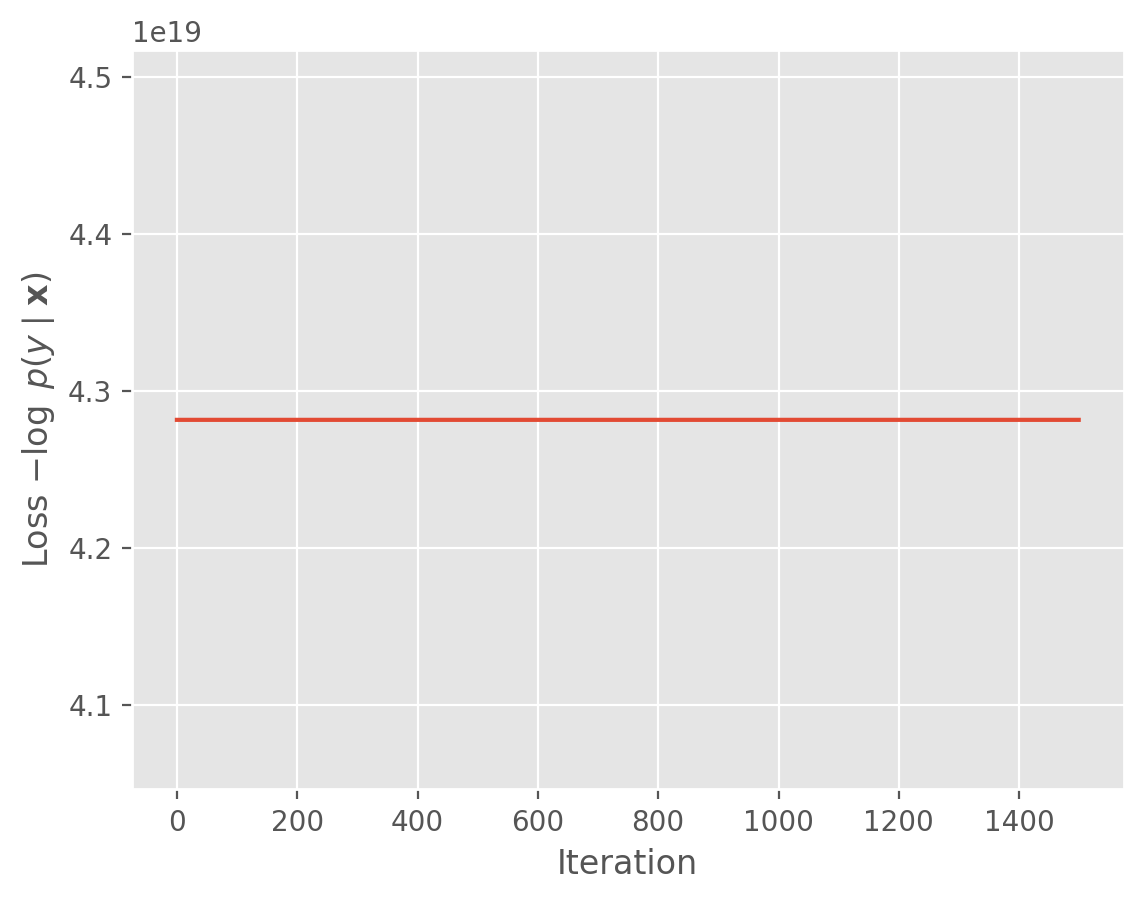

In [29]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

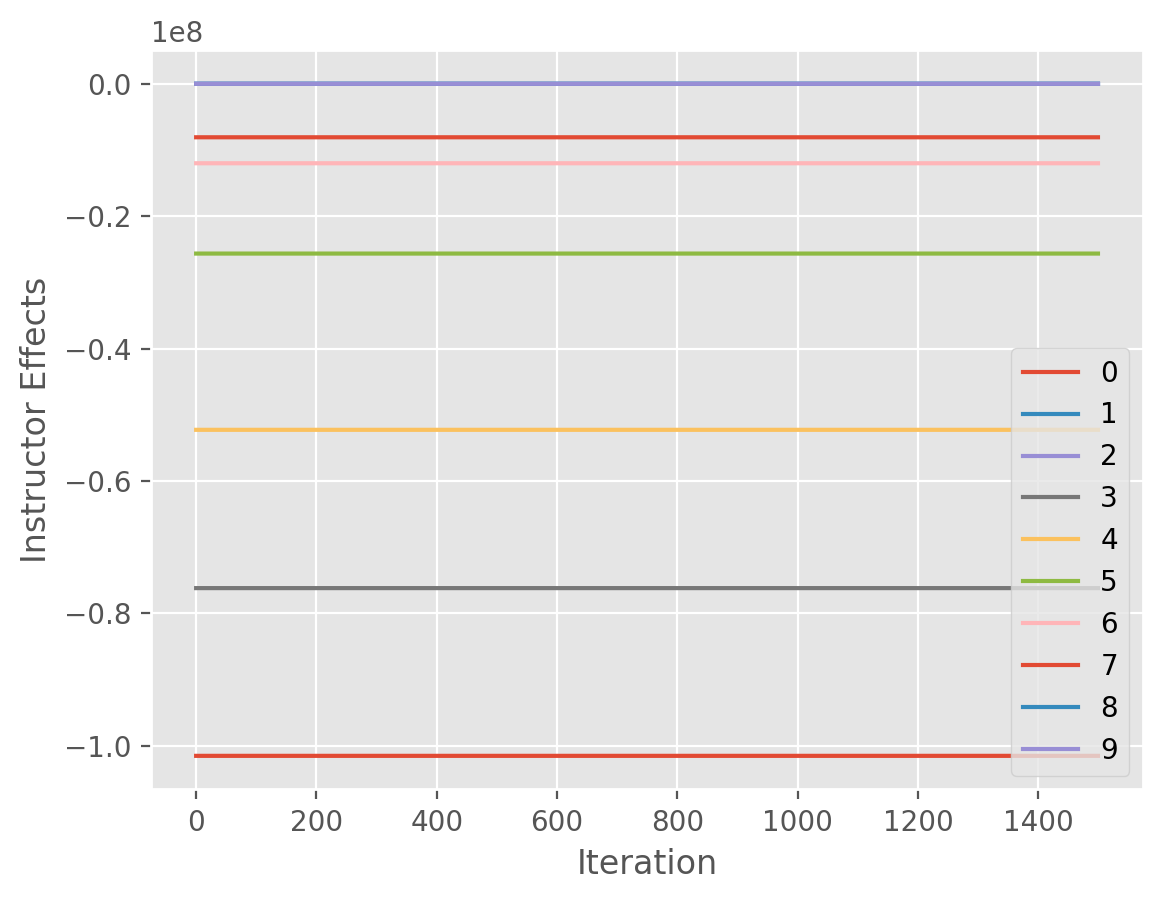

In [30]:
# TODO: Change plot to states effects once it's included in the model.
for i in range(10):
  plt.plot(effect_prior_deaths_samples[:, i])

plt.legend([i for i in range(10)], loc='lower right')
plt.ylabel('Instructor Effects')
plt.xlabel('Iteration')
plt.show()

In [31]:
lmm_test = lmm_jointdist(features_test)

effect_prior_deaths_mean = np.mean(effect_prior_deaths_samples, axis=0).astype(np.float32)


# Get the posterior predictive distribution
(*posterior_conditionals, ratings_posterior), _ = lmm_test.sample_distributions(
    value=(effect_prior_deaths_mean,))

ratings_prediction = ratings_posterior.mean()

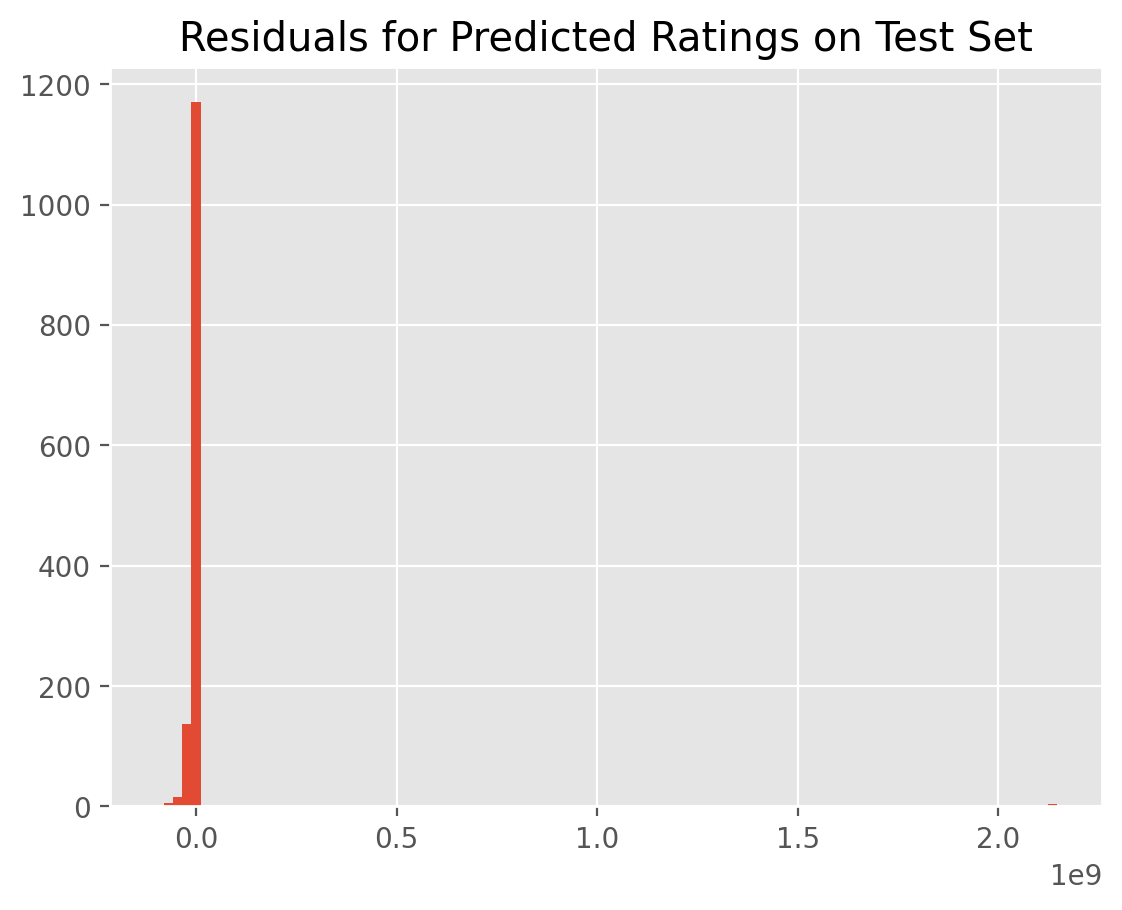

In [32]:
plt.title("Residuals for Predicted Ratings on Test Set")
plt.hist(ratings_prediction - labels_test, 100)
plt.show()

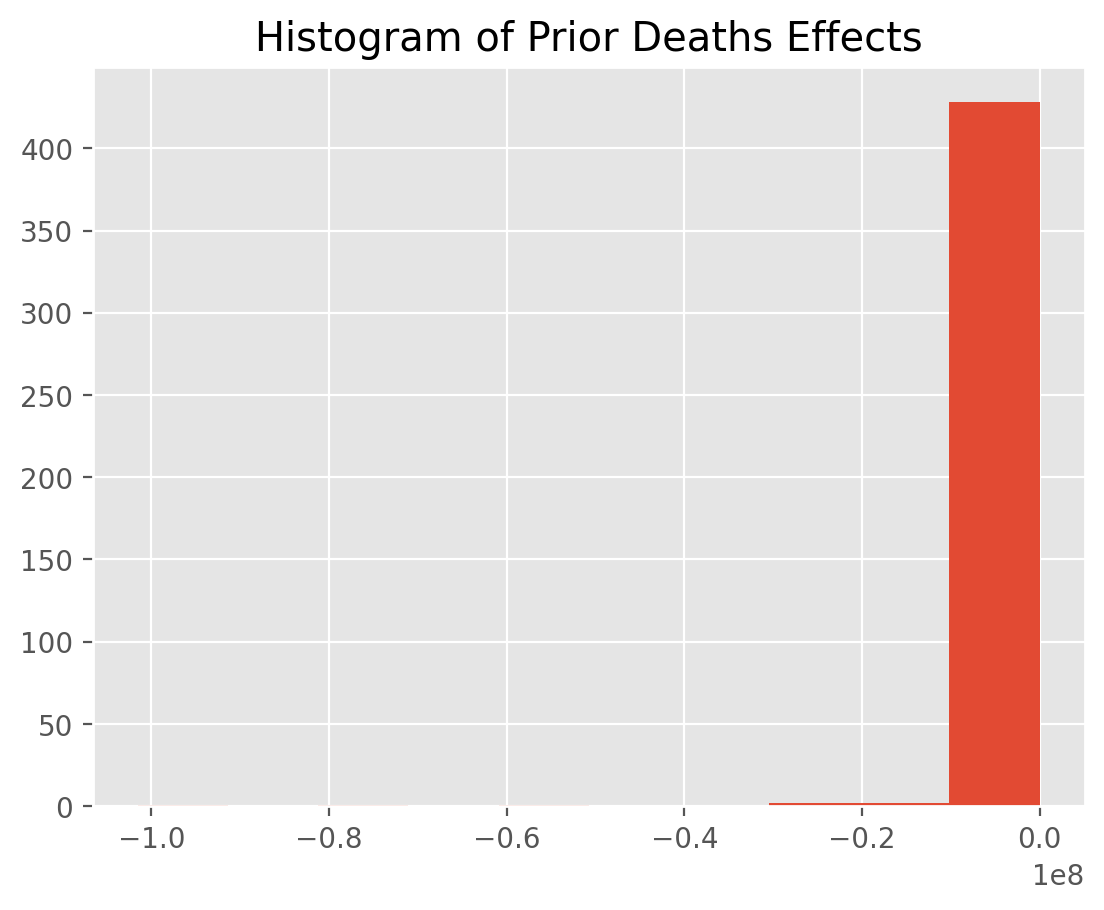

In [33]:
plt.title("Histogram of Prior Deaths Effects")
plt.hist(effect_prior_deaths_mean)
plt.show()